In [1]:
import sys
from os.path import basename

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier, XGBRFClassifier

sys.path.append("../../")

from helpers.split import tag_label_feature_split
from helpers.assess import make_classification_report, make_confusion_matrix

sns.set_style("darkgrid")
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

DATASET_FOLDER = "../../datasets/"

**MTG-Jamendo Dataset**

Our project uses  the MTG-Jamendo dataset.

It is built using music available at Jamendo under Creative Commons licenses and tags provided by content uploaders. The dataset contains over 55,000 full audio tracks with 195 tags from genre, instrument, and mood/theme categories.

As we describe in greater detail in our report, we limit our analysis to songs that are identified as belonging to exactly one of ten genres.  We eliminate songs in other genres.  We also eliminate songs labelled as belonging to more than one genre.

After flattening arrays, the dataset includes 2,654 features excluding mel spectrogram data.  We considered several collections of features, for example, one collection included all features in the dataset other than the mel spectrograms, another version consisted of just the mel spectrogram data.  In addition we looked at nine other combinations of features.

https://mtg.github.io/mtg-jamendo-dataset/

**Exploratory Data Analysis -- Class Imbalance**

The genres within the scope of our project are:

+ blues
+ classical
+ country
+ disco
+ hiphop
+ jazz
+ metal
+ genre_pop
+ reggae
+ rock

As noted above, we removed songs from the dataset that were labelled as being in other genres and we removed songs labelled as belonging to more than one of the genres listed above.

The exploratory data analysis that follows is on the version of the dataset that includes all of the features other than mel spectrograms, which we handle separately.  We refer to this dataset as our **all features** dataset.

In [2]:
# Read the data set

df = pd.read_pickle(DATASET_FOLDER + "dataset_00_all.pickle")

In [3]:
# Get labels, a label encoder and features using a utility function
# we wrote to separate labels and features from the MTG-Jamendo dataset
# and also to discard extraneous metadata.  The code for this function can
# be found in the helpers folder of the project repository.

_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
# Review the mapping between genre_ids and the genres themselves.

print(f'id genre\n-- -----')
for id, genre in enumerate(le.inverse_transform(range(10))):
    print (f'{id}  {genre[6:]}')

id genre
-- -----
0  blues
1  classical
2  country
3  disco
4  hiphop
5  jazz
6  metal
7  pop
8  reggae
9  rock


Our data is imbalanced.  The pop, classical and rock genres dominate the dataset.  At the other end of the spectrum, blues, country and disco are under represented.  We see this as an artifact of this particular data set only and not reflective of anything more.  Many of the models we work with provide a parameter that takes into account class imbalance and weights accordingly based on inverse population proportion to enhance the significance of individual data points from under represented classes.  We utitilize that approach when we can.  In some cases, which we describe below, we look to other means to address the imbalance.

In [5]:
pd.DataFrame(le.inverse_transform(y), columns=['genre']).value_counts()

genre          
genre_pop          5343
genre_classical    5276
genre_rock         4000
genre_hiphop       2126
genre_jazz         1552
genre_reggae        985
genre_metal         831
genre_blues         468
genre_country       409
genre_disco         361
dtype: int64

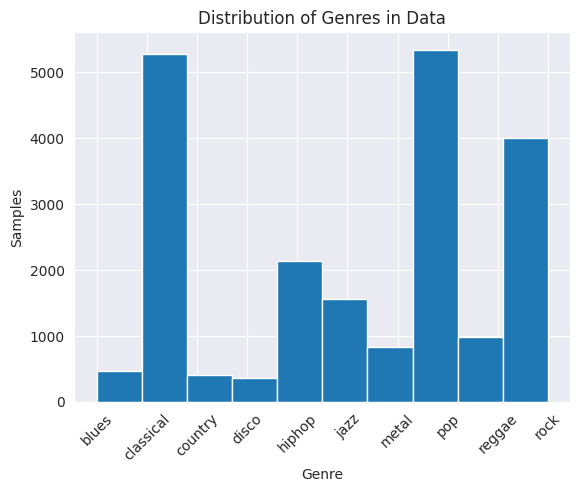

In [6]:
x_labels = [label[6:] for label in le.inverse_transform(range(10))]
plt.hist([y])
plt.title("Distribution of Genres in Data")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.xticks(range(10), x_labels, rotation=45)
plt.show()

As mentioned above, the complete feature set comprises 2,654 features.  We discuss features below.

In [7]:
# review the shapes
print(f"{X.shape= } {y.shape= }")

X.shape= (21351, 2654) y.shape= (21351,)


**Preprocessing**

We set aside 20% of our data for testing and use a stratified split, with shuffling, since we have a multi-class problem.  Ultimately, we relied on k-fold cross validation so we do not separate out a validation set from the training set at this juncture.

In [8]:
# split the data for training and testing with shuffling and stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1962, shuffle=True, stratify=y
)

In [9]:
# review the shapes
print(f"{X_train.shape = }\t{y_train.shape = }")
print(f"{X_test.shape =  }\t{y_test.shape =  }")

X_train.shape = (17080, 2654)	y_train.shape = (17080,)
X_test.shape =  (4271, 2654)	y_test.shape =  (4271,)


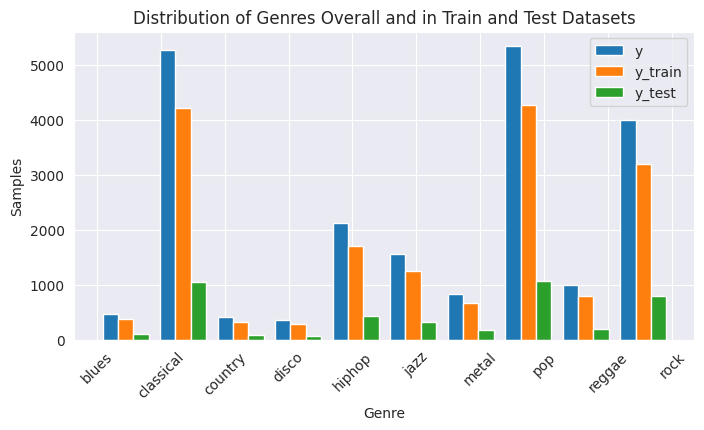

In [10]:
# reconfirm the distribution across the various sets
plt.figure(figsize=(8,4))
plt.hist([y, y_train, y_test],
         label=['y', 'y_train', 'y_test'])
plt.xticks(range(10), x_labels, rotation=45)
plt.title("Distribution of Genres Overall and in Train and Test Datasets")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

While some models (such as extreme gradient boost) do not require feature scaling or standardization for best performance, most do.  Morever, principal component analysis and some SMOTE-related sampling approaches also benefit from feature scaling or standardization.  Therefore we apply standardization to our feature as a general rule.  

When we work with principal component analysis or SMOTE and SMOTE-related sampling we extended the pre-processing pipeline beyond standardization as the situation warranted.  Our approach to principal component analysis is to use a sufficient number of components to capture 95% of the variance in the underlying data.

As shown below, we are able to capture 95% of the variance in our all features dataset with 387 principal components, a meaningful reduction from the 2,654 components presented in the dataset originally. We will make further use of principal component analysis to visualize our data in the exploratory data analysis included below.

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca=PCA(random_state=1962, n_components=.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [12]:
# review the shapes
print(f"{X_train_scaled.shape = }\t{y_train.shape = }")
print(f"{X_test_scaled.shape  =  }\t {y_test.shape =  }")
print(f"{X_train_pca.shape    = }\t{y_train.shape = }")
print(f"{X_test_pca.shape     =  } \t {y_test.shape =  }")

X_train_scaled.shape = (17080, 2654)	y_train.shape = (17080,)
X_test_scaled.shape  =  (4271, 2654)	 y_test.shape =  (4271,)
X_train_pca.shape    = (17080, 387)	y_train.shape = (17080,)
X_test_pca.shape     =  (4271, 387) 	 y_test.shape =  (4271,)


**Exploratory Data Analysis -- Features**

Machine learning work on audio typically relies on various features extracted from the underlying audio signal.  The signal processing involved is complex and a meaningful discussion is well beyond the scope of this project.

Our goal was to seek features in the data conventionally understood to be useful for genre classification as opposed to other kinds of audio processing, such as identifying particular instruments or working with speech.

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression that might potentially reduce the transmission bandwidth and the storage requirements of audio signals.

This very cursory introduction appears at https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

**need to insert a useful reference and revise the text, I'm not wild about referencing wikipeda**
**this is a really crude first cut and I don't get to mel spectrograms at all**

Many music genre classification models rely to a large degree on MFCCs.  To that end, we paid particular attention to MFCC data available to us in the dataset.  In particular, the values of thirteen MFCC coefficients, as well as MFCC related variance, covariance and inverse covariance data points presented in the dataset.

We also ran a series of statistical tests to identify features in the dataset that appear to have statistically meaningful relationships to the various genres.  We identified ten features using a p-value driven approach.

In [13]:
# Useful stuff from someone smarter than me goes here. . .

**Exploratory Data Analysis -- Features -- Principal Component Analysis**

With so many features and classes, we struggled to visualize our data before building our models.  We found that principal component analysis gave us a perspective on the richness and complexity of our data.

The following plot illustrates the ability of PCA to capture information in order to reduce dimensionality.

The plots resuling from the application of PCA to our other dataset variations were not meaningfully different than what we show for our all features dataset.

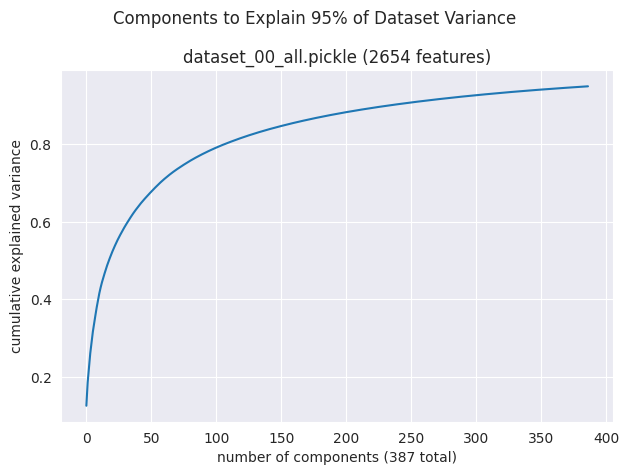

In [14]:
dataset = "../../datasets/dataset_00_all.pickle"
fig, ax = plt.subplots()
fig.suptitle("Components to Explain 95% of Dataset Variance")

original_features = X_train.shape[1]

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_title(f"{basename(dataset)} ({original_features} features)")
ax.set(
    xlabel=f"number of components ({pca.components_.shape[0]} total)",
    ylabel="cumulative explained variance",
)

plt.tight_layout()
plt.show()
fig.savefig("pca-slide-1.png")

The following two dimensional scatter plot shows our dataset viewed through the lens of just the first two principal components.  While some genres appear to be more readily discernible, others are not.  Separating out this dataset has been challenging and this plot starts to give us a sense of why.

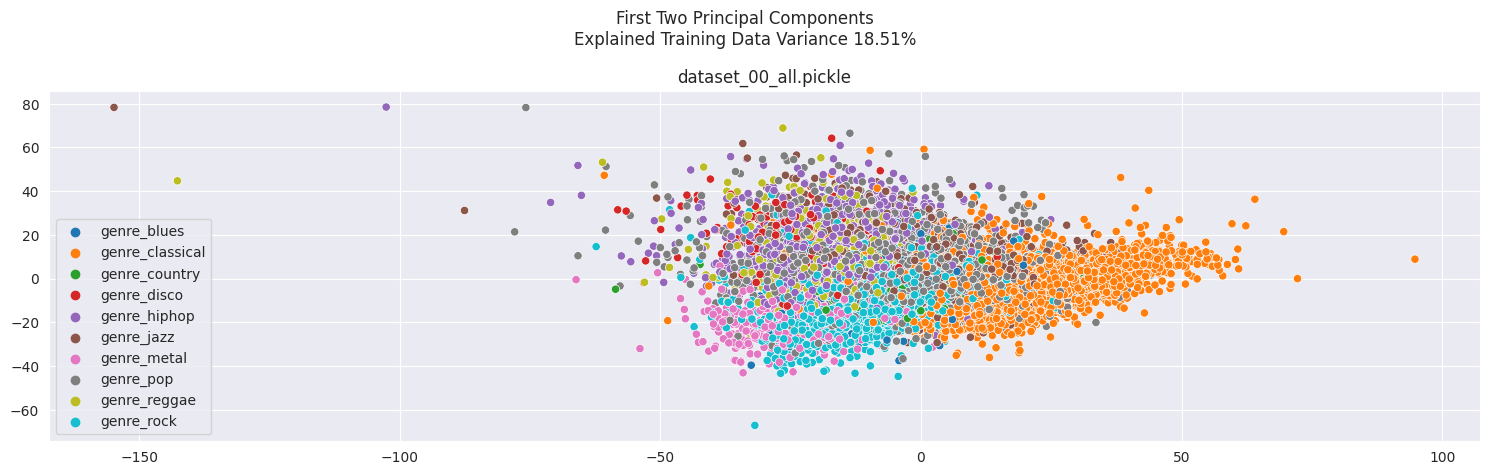

In [15]:
pca_2 = PCA(n_components=2)

# Fit PCA with training features only

X_train_pca_2 = pca_2.fit_transform(X_train_scaled)
X_test_pca_2 = pca_2.transform(X_test_scaled)

# Concatenate test and train data for visualization only

X_pca_2 = np.concatenate((X_train_pca, X_test_pca), axis=0)
y_merged = np.concatenate((y_train, y_test), axis=0)

explanation_ratio = round(sum(pca_2.explained_variance_ratio_[0:2]) * 100, 2)

fig, ax_2d = plt.subplots(figsize=(15, 4.8))
fig.suptitle(
    f"First Two Principal Components\nExplained Training Data Variance {explanation_ratio}%"
)

hue_order = list(le.inverse_transform(range(10)))

sns.scatterplot(
    x=X_pca_2[:, 0],
    y=X_pca_2[:, 1],
    hue=le.inverse_transform(y_merged),
    hue_order=hue_order,
    ax=ax_2d,
    cmap=cmap
).set(title=basename(dataset))


plt.tight_layout()
plt.show()
fig.savefig("pca-slide-2.png")

We wanted to see if adding a third component to the mix might make it easier to separate our classes.  The following three dimensional scatterplot was the result.  Again, this is on our all features dataset.  When we applied this methodology to other renditions of our dataset we did not see anything meaningfully different.  In some cases the data looked reasonably similar to the plot we show below.  In other cases, the data was even more condensed.

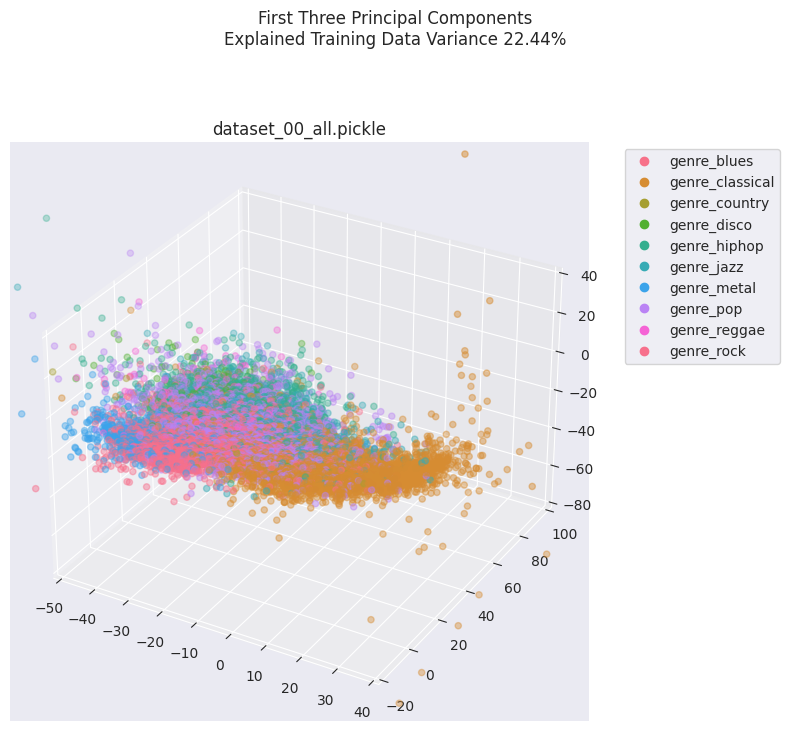

In [16]:
pca_3 = PCA(n_components=3)

# Fit PCA with training features only

X_train_pca_3 = pca_3.fit_transform(X_train_scaled)
X_test_pca_3 = pca_3.transform(X_test_scaled)

# Concatenate test and train data for visualization only

X_pca_3 = np.concatenate((X_train_pca_3, X_test_pca_3), axis=0)
y_merged = np.concatenate((y_train, y_test), axis=0)

explanation_ratio = round(sum(pca_3.explained_variance_ratio_[0:3]) * 100, 2)


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

fig.suptitle(
    f"First Three Principal Components\nExplained Training Data Variance {explanation_ratio}%"
)


pca_3_1 = X_pca_3[:, 0]
pca_3_2 = X_pca_3[:, 1]
pca_3_3 = X_pca_3[:, 2]


scatter = ax.scatter(pca_3_1, pca_3_2, pca_3_3, c=y_merged, cmap=cmap)
plt.legend(
    scatter.legend_elements()[0],
    list(le.inverse_transform(range(10))),
    bbox_to_anchor=(1.05, 1),
    loc=2,
)

ax.set_title(basename(dataset))
ax.set_xlim(-50, 40)
ax.set_ylim(-20, 100)
ax.set_zlim(-80, 40)
plt.tight_layout()
plt.show()
fig.savefig("pca-slide-3.png")

**We clearly need to enhance what's above, but I hope you agree this is generally OK.  I need you to take it from here and build out our modelling discussion.  I'm not sure how much you want to get into the stuff I did with Bayesian hyper parameter tuning since I don't think we embraced this more generally and I have little to show.**

**We also need a section on evaluation metrics, but I'm too worn out to worry about that now and it may make more sense to write that when we we how the modelling section looks**